2024-11-19 05:14:08.960613: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-11-19 05:14:08.960640: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2024-11-19 05:14:08.960646: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2024-11-19 05:14:08.960660: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-19 05:14:08.960670: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/opt/anaconda3/envs/DLvirt/lib/python3.9/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, 1, 1). This axis has s

Epoch 1/60


2024-11-19 05:14:09.761719: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.7550 - loss: 0.8301 - val_accuracy: 0.9466 - val_loss: 0.1304
Epoch 2/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9521 - loss: 0.1397 - val_accuracy: 0.9767 - val_loss: 0.0672
Epoch 3/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9718 - loss: 0.0881 - val_accuracy: 0.9760 - val_loss: 0.0763
Epoch 4/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9737 - loss: 0.0825 - val_accuracy: 0.9740 - val_loss: 0.0647
Epoch 5/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9719 - loss: 0.0841 - val_accuracy: 0.9781 - val_loss: 0.0754
Epoch 6/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9735 - loss: 0.0786 - val_accuracy: 0.9795 - val_loss: 0.0609
Epoch 7/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9809 - loss: 0.0498 - val_accuracy: 0.9842 - val_loss: 0.0542
Epoch 8/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9708 - loss: 0.0870 - val_accuracy: 0.976

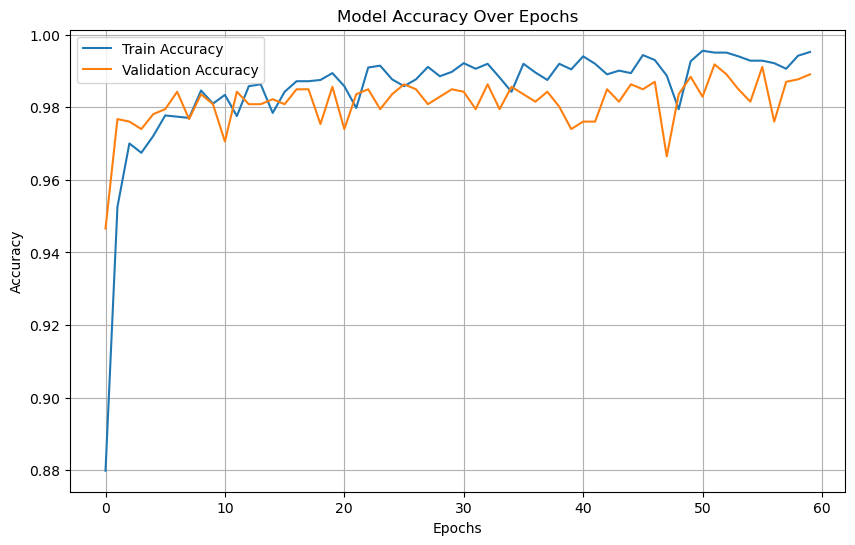

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D, Reshape

data = pd.read_csv('./DSA_features.csv')

X = data.drop(columns=['activity', 'people'])
y = data['activity']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

class TransformerEncoder(Model):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerEncoder, self).__init__()
        self.attention = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Dense(ff_dim, activation="relu")
        self.projection = Dense(embed_dim)
        self.ffn_projection = Dense(embed_dim)
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.attention(inputs, inputs)
        attn_output = self.projection(attn_output)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        
        ffn_output = self.ffn(out1)
        ffn_output = self.ffn_projection(ffn_output)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

def build_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    x = Reshape((1, input_shape[0]))(inputs)
    
    x = TransformerEncoder(embed_dim=input_shape[0], num_heads=4, ff_dim=256)(x)
    
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.2)(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.2)(x)
    outputs = Dense(num_classes, activation="softmax")(x)
    
    model = Model(inputs, outputs)
    return model

input_shape = (X_train.shape[1],)
num_classes = len(np.unique(y_train))
model = build_model(input_shape, num_classes)

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=60,
    batch_size=32,
    verbose=1
)

loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print("Test Accuracy:", accuracy)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()